# Textual Phenomena

This notebook deals with typical structures examined in natural language processing, including preprocessing (tokenisation, part-of-speech tagging), morpholigical analysis (lemmatisation), morphosyntactic analysis (dependency parsing, sentence splitting, clause/tense/mood/voice/modality tagging), semantic analysis (named entity regognition and entity linking, emotion analysis, tagging of temponyms and verb/adjective categories), speech and speaker analysis and coreference analysis.
Higher level narrative structures such as literary events or reflective passages are examined in notebook 3.

The code package MONAPipe provides new pipeline components for spaCy. This notebook also shows how to use them.

## Imports
At first we import the components from MONAPipe that we want to use:

In [21]:
# import statements
import os
import spacy
import sys

# import pipeline components
sys.path.append(os.path.join(os.getcwd(), "../pipy-public"))
from pipeline.components.analyzer import demorphy_analyzer
from pipeline.components.clausizer import dependency_clausizer
from pipeline.components.coref import rb_coref
from pipeline.components.emotions_tagger import nrc_emotions
from pipeline.components.entity_linker import wikidata_entity_linker
from pipeline.components.sentencizer import nltk_sentencizer, spacy_sentencizer
from pipeline.components.speech_tagger import flair_speech_tagger, quotation_marks_speech_tagger
from pipeline.components.temponym_tagger import heideltime_temponym_tagger
from pipeline.components.tense_tagger import rb_tense_tagger
from settings import PARSING_PATH

We further import classes from the `tgclients` library to load texts from the Textgrid Repository.

In [22]:
# import TextGrid components
from tgclients.aggregator import Aggregator
aggregator = Aggregator()

## Loading the pipeline 

In the next step we build our first pipeline: The pipeline is initialized via the `spacy.load()`-method and stored in the variable `nlp`. (Here, we load a language model `"de_ud_lg"` that comes with MONAPipe.) Each pipeline already has the components `tagger` (part-of-speach tagger), `parser` (dependency parser), `ner` (named entity recognizer) right from the start.

With the `add_pipe` method, we can add further components. Since the `"de_ud_lg"` model has no built-in sentencizer (sentence splitter), we have to load a sentencizer before the parser, so that the parser can work properly. In general, it is important to define the pipeline in the correct order, e.g. for using the `clausizer`, we first have to add the `sentencizer`.

Pipeline components have a `name` (e.g. `"sentencizer"`) and a specific implementation that must be specified –– for example, below, we use the `spacy_sentencizer` (which relies on an external spaCy model). Each component can have several implementations, e.g. `sentencizer` has a second implementation `nltk_sentencizer` (which relies on the NLTK library). If you are interested, you can open each component file in `pipeline/components/[name_of_the_component].py`; methods that are described as `Spacy pipeline component` can be used with the `add_pipe` method. You can also find according information in the MONAPipe README.

In [23]:
# create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(demorphy_analyzer, name="analyzer")
nlp.add_pipe(dependency_clausizer, name="clausizer")

In [24]:
# show components currently part of the pipeline
print(nlp.pipe_names)

['tagger', 'sentencizer', 'parser', 'ner', 'analyzer', 'clausizer']


## Loading a text

To find a text in the TextGrid repository, we can use the search interface here: https://textgridrep.org.
Each text in the TextGrid repository has a unique identifier (TextGrid URI) that we need to load the text via the `tgclients` library from TextGrid. For example, if we search for `Fontane Stechlin` in the interface, we find Theodor Fontane's *Der Stechlin* as second hit. When clicking on it, the url of the website switches to the following:  `https://textgridrep.de/browse/n143.0`. Here, the string after the last slash (`n143.0`) is the TextGrid uri.
In the next step, we can use the uri in conjunction with the namespace `textgrid` to load Fontane's novel as plain text.

In [25]:
# Load the text from TextGrid repository:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text

In [26]:
# The variable `text_fontane_stechlin` contains the complete text as plain text.
# We can print a sclice of it to inspect the content:
print(text_fontane_stechlin[0:485])

Theodor Fontane
Der Stechlin
Roman
Schloß Stechlin
1. Kapitel
Erstes Kapitel
Im Norden der Grafschaft Ruppin, hart an der mecklenburgischen Grenze, zieht sich von dem Städtchen Gransee bis nach Rheinsberg hin (und noch darüber hinaus) eine mehrere Meilen lange Seenkette durch eine menschenarme, nur hie und da mit ein paar alten Dörfern, sonst aber ausschließlich mit Förstereien, Glas- und Teeröfen besetzte Waldung. Einer der Seen, die diese Seenkette bilden, heißt »der
Stechlin
«.


To run our above defined nlp pipeline, we call it from the `nlp`-variable, where the pipeline definition is stored in an object. We pass the text to the object, which creates the so called `doc` object – this is one of the main objects of spaCy.

In [27]:
# Pipe text through the pipeline:
doc_fontane_stechlin = nlp(text_fontane_stechlin[76:9500])

In [28]:
# Print first tokens of doc object:
print(doc_fontane_stechlin[0:300])


Im Norden der Grafschaft Ruppin, hart an der mecklenburgischen Grenze, zieht sich von dem Städtchen Gransee bis nach Rheinsberg hin (und noch darüber hinaus) eine mehrere Meilen lange Seenkette durch eine menschenarme, nur hie und da mit ein paar alten Dörfern, sonst aber ausschließlich mit Förstereien, Glas- und Teeröfen besetzte Waldung. Einer der Seen, die diese Seenkette bilden, heißt »der
Stechlin
«. Zwischen flachen, nur an einer einzigen Stelle steil und quaiartig ansteigenden Ufern liegt er da, rundum von alten Buchen eingefaßt, deren Zweige, von ihrer eignen Schwere nach unten gezogen, den See mit ihrer Spitze berühren. Hie und da wächst ein weniges von Schilf und Binsen auf, aber kein Kahn zieht seine Furchen, kein Vogel singt, und nur selten, daß ein Habicht drüber hinfliegt und seinen Schatten auf die Spiegelfläche wirft. Alles still hier. Und doch, von Zeit zu Zeit wird es an eben dieser Stelle lebendig. Das ist, wenn es weit draußen in der Welt, sei's auf Island, sei's a

## Levels for textual phenomena

Textual phenomena can cover longer spans of text or shorter snippets with only one or a few tokens. Accordingly, they are either attributed to a `Doc`, `Token` or `Span` object:

- `Doc`-level phenomena apply to the entire document. One could, for example, store meta data about a text at the `Doc`-level. We will see another example in Notebook 4.
- `Token`-level phenomena apply to single words. Examples include part of speech, lemma or syntactic dependency relation.
- `Span`-level phenomena are very flexible, since spans can be anything from a few words to large text segments. Certain pipeline components define specific spans which can then, after their definition, receive attributes. We already know that sentences are spans. Other examples are:
    - The `ner` component (spaCy) defines named entities, which typically span not more than a few words.
    - The `clausizer` component (MONAPipe) defines clauses, which are linguistic units within a sentence.

We will see specific examples in the following.

### Token-Level

#### Part-of-Speech tags

Each word or token has a part of speech (POS), which is the grammatical category (e.g. noun, verb, adjective) of the word. SpaCy's `tagger` component assigns POS tags to each token. To get the POS of a token, we need to add `.pos_` to the token.

Here is the list of part-of-speech abbreviations used in spaCy:

**ADJ** adjective <br>
**ADP** adposition <br>
**ADV** adverb <br>
**AUX** auxiliary <br>
**CONJ** conjunction <br>
**CCONJ** coordinating conjunction <br>
**DET** determiner <br>
**INTJ** interjection <br>
**NOUN** noun <br>
**NUM** numeral <br>
**PART** particle <br>
**PRON** pronoun <br>
**PROPN** proper noun <br>
**PUNCT** punctuation <br>
**SCONJ** subordinating conjunction <br>
**SYM** symbol <br>
**VERB** verb <br>
**X** other <br>
**SPACE** empty space <br>

In [29]:
for token in doc_fontane_stechlin[1:60]:
    print(token, token.pos_)

Im ADP
Norden NOUN
der DET
Grafschaft NOUN
Ruppin PROPN
, PUNCT
hart ADJ
an ADP
der DET
mecklenburgischen ADJ
Grenze NOUN
, PUNCT
zieht VERB
sich PRON
von ADP
dem DET
Städtchen NOUN
Gransee PROPN
bis ADP
nach ADP
Rheinsberg PROPN
hin ADP
( PUNCT
und CCONJ
noch ADV
darüber ADV
hinaus ADP
) PUNCT
eine DET
mehrere DET
Meilen NOUN
lange ADJ
Seenkette NOUN
durch ADP
eine DET
menschenarme NOUN
, PUNCT
nur ADV
hie ADV
und CCONJ
da ADV
mit ADP
ein DET
paar DET
alten ADJ
Dörfern NOUN
, PUNCT
sonst ADV
aber ADV
ausschließlich ADV
mit ADP
Förstereien NOUN
, PUNCT
Glas- X
und CCONJ
Teeröfen NOUN
besetzte ADJ
Waldung NOUN
. PUNCT


#### Emotion Tagger

The emotion tagger is a pipeline component that assigns scores for positive/negative sentiments and Ekman (1992)'s basic emotions to each token. These basic emotions are "Anger", "Anticipation", "Disgust", "Fear", "Joy", "Sadness", "Surprise", and "Trust". This component is vocabulary-based and does not take context information into consideration. The output is a dictionary of the form {"Sentiment / Emotion": score}

We build a new pipeline including the emotions tagger. This time we exclude the dependency parser and the named entity recognizer.

In [30]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"), disable=["parser", "ner"])
# Add components
nlp.add_pipe(nrc_emotions, name="emotions_tagger")
print(nlp.pipe_names)

['tagger', 'emotions_tagger']


To get the emotions at a token, we need to add `._.emotions` to the token. The extra `._` (compared to `.pos_` above) indicates that `.emotions` is a custom attribute (whereas `.pos_` is a built-in attribute). All attributes coming from MONAPipe thus have this extra `._`.

In [31]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc_goethe_wahlverwandtschaften = nlp(text_goethe_wahlverwandtschaften[20883:20978])
print(doc_goethe_wahlverwandtschaften, "\n")
for token in doc_goethe_wahlverwandtschaften:
    print(token.i, token, token._.emotions)

Du siehst, wir tragen beiderseits dieselben Sorgen in einem treuen, freundschaftlichen Herzen.  

0 Du {}
1 siehst {}
2 , {}
3 wir {}
4 tragen {'Positive': '0', 'Negative': '0', 'Anger': '0', 'Anticipation': '0', 'Disgust': '0', 'Fear': '0', 'Joy': '0', 'Sadness': '0', 'Surprise': '0', 'Trust': '0'}
5 beiderseits {}
6 dieselben {}
7 Sorgen {'Positive': '0', 'Negative': '1', 'Anger': '0', 'Anticipation': '1', 'Disgust': '0', 'Fear': '1', 'Joy': '0', 'Sadness': '1', 'Surprise': '0', 'Trust': '0'}
8 in {}
9 einem {}
10 treuen {'Positive': '1', 'Negative': '0', 'Anger': '0', 'Anticipation': '0', 'Disgust': '0', 'Fear': '1', 'Joy': '1', 'Sadness': '0', 'Surprise': '1', 'Trust': '1'}
11 , {}
12 freundschaftlichen {'Positive': '1', 'Negative': '0', 'Anger': '0', 'Anticipation': '0', 'Disgust': '0', 'Fear': '0', 'Joy': '1', 'Sadness': '0', 'Surprise': '0', 'Trust': '0'}
13 Herzen {'Positive': '0', 'Negative': '0', 'Anger': '0', 'Anticipation': '0', 'Disgust': '0', 'Fear': '0', 'Joy': '0', 'Sad

### Span-Level

#### Named entites

Named Entity Regognition (NER) is one of the important classification tasks in semantic analysis. The term named entity simply means anything that can be referred to with a proper name.
In the next cell, we print the named entites categorized as persons (PER) respectively locations (LOC) occuring in our current document (note that the named-entity type is an attribute of each token within the entity and not of the entity span).

We can get the entity type of a named entity by appending `.ent_type_` to any token of the named entity.

In [32]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"), disable=["parser"])
print(nlp.pipe_names)

['tagger', 'ner']


In [33]:
# Load the text from TextGrid repository:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
# Pipe text through the pipeline:
doc_fontane_stechlin = nlp(text_fontane_stechlin[76:9500])

In [34]:
# LOC (location) entities
for ent in doc_fontane_stechlin.ents:
    if ent[0].ent_type_ == "LOC":
        print(ent)

Grafschaft Ruppin
mecklenburgischen Grenze
Gransee
Rheinsberg
Hie
Island
Südsee
Stechlin
Großes
Lissabon
Stechlin
Stechlin
Stechlin
herumzieht
Kloster Wutz
Kastanienallee
Dorf Stechlin
Schwefelfäden
Pfarrhause
Kirchhof lehnan
Rundbogenportals
Kastanienallee
Bohlenbrücke
Stechlin
Stechlin
Schloßgraben
Stechlin
Hohenzollern
Schleswig
Märkischen
Brandenburg
Stechlin
Insel Usedom
Märkischer
Friesack


In [35]:
for ent in doc_fontane_stechlin.ents:
    if ent[0].ent_type_ == "PER":
        print(ent)

sich's
brodelt's
Jenseits
Friedrich Wilhelms I.
Schloßherrn
Aloeblätter
Dubslav von Stechlin
Major a. D.
Beinah
Paradoxen
Schloßherrn
Friedrich Wilhelms IV.
Anno vierundsechzig
Dubslav
Dubslav
Joachim
Woldemar
Raoul
Dubslav von Stechlin


#### Named Entities - Hands-on

As seen above, the Named Entity Recognition gives out all occurences of named entities in a given text. As a consequence, names that occur several times in the text occur as many times in the list as well (e.g. 'Dubslav'). 

In the following exercise, we would like to compare two fictional texts regarding the variety of characters occuring in them. In the following cell, we load snippets of Kafka's 'Der Prozess' and of Fontane's 'Der Stechlin' as two text variables of equal length. We then pass them to our `nlp` object which creates two `doc` objects containing the processed texts. 

Run the following cell. Afterwards, write your own code to figure out...
1) ... how many occurences of named personal entities there are in each text.
2) ... how many different names of personal entities occur in each text.
3) ... what's the quantitive relation between occurences of named personal entities and the number of occuring names.

Discuss your results: Do they reveal any interesting differences between the two texts? How reliable is the method to make statements about the texts? 

In [36]:
# load the texts and run the pipeline
text_kafka_prozess = aggregator.text("textgrid:qmx4.0").text
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
doc_fontane_stechlin = nlp(text_fontane_stechlin)
doc_kafka_prozess = nlp(text_kafka_prozess)

In [37]:
# Your code here:









# (You find a possible solution in the next cell)

##### possible solution
```
ents_fontane = [ent.text for ent in doc_fontane_stechlin.ents if ent[0].ent_type_ == "PER"]
individual_ents_fontane = len(set(ents_fontane))
all_ents_fontane = len(ents_fontane)
relation_fontane = individual_ents_fontane / all_ents_fontane
ents_kafka = [ent.text for ent in doc_kafka_prozess.ents if ent[0].ent_type_ == "PER"]
individual_ents_kafka = len(set(ents_kafka))
all_ents_kafka = len(ents_kafka)
relation_kafka = individual_ents_kafka / all_ents_kafka
print(all_ents_fontane)
print(all_ents_kafka)
print(individual_ents_fontane)
print(individual_ents_kafka)
print(relation_fontane)
print(relation_kafka)
```

#### Entity Linking
Entity Linking means assigning an identifier of a certain knowledge base to the named entity. We use the free and open knowledge base Wikidata for our entity linker. 

We have to define a new pipeline that includes the entity linker. Since the entity linker is still in developement, we only pipe short snippets of text for PER and LOC entities in the next cells.

> Florian Barth, Hanna Varachkina, Tillmann Dönicke, and Luisa Gödeke (2022). [Levels of Non-Fictionality in Fictional Texts](http://www.lrec-conf.org/proceedings/lrec2022/workshops/ISA-18/pdf/2022.isa18-1.4.pdf). In Proceedings of The Eighteenth Joint ACL - ISO Workshop on Interoperable Semantic Annotation.

In [38]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# Add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(demorphy_analyzer, name="analyzer")
nlp.add_pipe(dependency_clausizer, name="clausizer")
nlp.add_pipe(rb_coref, name="coref")
nlp.add_pipe(wikidata_entity_linker, name="entity_linker")
print(nlp.pipe_names)

['tagger', 'sentencizer', 'parser', 'ner', 'analyzer', 'clausizer', 'coref', 'entity_linker']


**Note:** The entity linker performs a variety of requests to Wikidata. When multiple users from the same server (as we have with the JupyterHub) use the entity linker at once, this may lead to a long runtime and occacionally errors. If this happens for you, try again later or skip the cells. 😿

In [39]:
# Load snippet with LOC entities
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
text_fontane_stechlin = text_fontane_stechlin[77:485] # select text snippet, leave as is
doc_fontane_loc = nlp(text_fontane_stechlin)
print("Text Snippet: ", doc_fontane_loc)

Entity Linker in progress...
Text Snippet:  Im Norden der Grafschaft Ruppin, hart an der mecklenburgischen Grenze, zieht sich von dem Städtchen Gransee bis nach Rheinsberg hin (und noch darüber hinaus) eine mehrere Meilen lange Seenkette durch eine menschenarme, nur hie und da mit ein paar alten Dörfern, sonst aber ausschließlich mit Förstereien, Glas- und Teeröfen besetzte Waldung. Einer der Seen, die diese Seenkette bilden, heißt »der
Stechlin
«.


In [41]:
for ent in doc_fontane_loc.ents:
    if ent[0].ent_type_ == "LOC":
        print(ent)
        if ent._.entity.wikidata_id:
            print(f"https://www.wikidata.org/wiki/{ent._.entity.wikidata_id}")
        print("\n")

Grafschaft Ruppin
https://www.wikidata.org/wiki/Q30904844


mecklenburgischen Grenze


AttributeError: 'Entity' object has no attribute 'wikidata_id'

In [42]:
# Load snippet with PER entities
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
text_fontane_stechlin = text_fontane_stechlin[412307:412502] # select text snippet, leave as is
doc_fontance_per = nlp(text_fontane_stechlin)
print("Text Snippet: ", doc_fontance_per)

Entity Linker in progress...
Text Snippet:  Ein wahres Glück, daß König Friedrich Wilhelm IV. diese jetzt etablierte Niedergangsepoche nicht mehr erlebt hat, diese Zeit des Abfalls, so recht eigentlich eine Zeit der Apokalyptischen Reiter.


In [43]:
for ent in doc_fontance_per.ents:
    if ent[0].ent_type_ == "PER":
        print(ent)
        if ent._.entity.wikidata_id:
            print(f"https://www.wikidata.org/wiki/{ent._.entity.wikidata_id}")
        print("\n")

Friedrich Wilhelm IV.
https://www.wikidata.org/wiki/Q57180


Niedergangsepoche


AttributeError: 'Entity' object has no attribute 'wikidata_id'

#### Temponyms (temporal marker)

The TemponymTagger extracts and normalises temporal expressions from a document. It distinguishes four types: `time`, `duration`, `date`, `set`. Each type has a specific encoding (`NORM_VALUE`) which represents the temporal expression in a normalised way (see examples in the next cells).

The original algorithm presented in Strötgen & Gertz (2010) was re-implemented for spaCy by Barth & Dönicke (2021), using the [German resource files](https://github.com/HeidelTime/heideltime/tree/master/resources/) from [HeidelTime](https://github.com/HeidelTime/heideltime).

> Florian Barth and Tillmann Dönicke (2021). [Participation in the KONVENS 2021 Shared Task on Scene Segmentation Using Temporal, Spatial and Entity Feature Vectors](http://ceur-ws.org/Vol-3001/paper4.pdf). In Proceedings of the Shared Task on Scene Segmentation.

> Jannik Strötgen and Michael Gertz (2010). [Heideltime: High quality rule-based extraction and normalization of temporal expressions](https://www.aclweb.org/anthology/S10-1071.pdf). In Proceedings of the 5th International Workshop on Semantic Evaluation.


In [44]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# Add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(heideltime_temponym_tagger, name="temponym_tagger")
print(nlp.pipe_names)

['tagger', 'sentencizer', 'parser', 'ner', 'temponym_tagger']


In [45]:
text_verne_reise = aggregator.text("textgrid:wr7p.0").text
doc_verne_reise = nlp(text_verne_reise)

In [46]:
# function for extracting temponyms in sent
def temponyms_in_sent(sent) -> set():
    temponyms = set()
    for token in sent:
        if token._.in_temponym:
            for temponym in token._.temponyms:
                temponyms.add(temponym)
    return temponyms

In [47]:
# `date` and `time`
sent = doc_verne_reise[13537].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)


Am folgenden Morgen nach der Abfahrt aus Suez, den 29. October, traf er zu einigem Vergnügen auf dem Verdeck den gefälligen Mann, an welchen er sich bei seiner Landung in Aegypten gewendet hatte.
folgenden Morgen {'NORM_VALUE': 'UNDEF-next-dayTMO', 'TYPE': 'time'}
29. October {'NORM_VALUE': 'UNDEF-year-10-29', 'TYPE': 'date'}


In [48]:
# `duration` and `time`
sent = doc_verne_reise[1673].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)

Also von diesem Augenblicke an, elf Uhr neunundzwanzig Minuten Vormittags, Mittwochs, 2. October 1872, sind Sie in meinem Dienst.«
neunundzwanzig Minuten {'NORM_VALUE': 'PT29M', 'TYPE': 'duration'}
2. October 1872 {'NORM_VALUE': '1872-10-02', 'TYPE': 'date'}


In [49]:
# `set`
sent = doc_verne_reise[39693].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)


– Ich biete Ihnen hundert Pfund täglich, und eine Prämie von zweihundert Pfund, wenn ich zeitig anlange.
täglich {'NORM_VALUE': 'P1D', 'TYPE': 'set'}


#### Clauses

Clauses are linguistic units that usually have their own verb and subject. Some sentences consist only of a main clause, whereas other sentences also have subordinate clauses (such as relative clauses). MONAPipe's `clausizer` splits a document into clauses, which can then be accessed through `doc._.clauses` and `sent._.clauses`.

In [50]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# Add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(demorphy_analyzer, name="analyzer")
nlp.add_pipe(dependency_clausizer, name="clausizer")
nlp.add_pipe(rb_tense_tagger, name="tense_tagger")

Let us first print the number of tokens, clauses and sentences in Jule Verne's *Reise um die Erde in 80 Tagen*:

In [51]:
text_verne_reise = aggregator.text("textgrid:wr7p.0").text
doc_verne_reise = nlp(text_verne_reise)

print(len(doc_verne_reise), len(doc_verne_reise._.clauses), len(list(doc_verne_reise.sents)))

77610 9157 4721


Clauses are `Span` objects and may have own attributes, such as `clause._.tokens`, which is a list of all tokens that belong to the clause. Punctuation that precedes or succeeds a clause is stored separately in `clause._.prec_punct` and `clause._.succ_punct`, respectively.

Other pipeline components add additional attributes to clauses. For example, MONAPipe's TenseTagger adds a `clause._.form`, which stores an object that contains a grammatical analysis of the clause. On can access this object, for example in the following ways:

- `clause._.form.verb_form`: `fin` (finite), `inf` (infinitive), `part` (participle);
- `clause._.form.tense`: `past` (past), `pres` (present), `fut` (future);
- `clause._.form.mode`: `imp` (imperative), `ind` (indicative), `subj:pres` (subjunctive I; German: Konjunktiv I), `subj:past` (subjunctive II; German: Konjunktiv II);
- `clause._.form.voice`: `active` (active), `pass:static` (static passive), `pass:dynamic` (dynamic passive);
- ...

Let us print some of these properties for all clauses in two sentences:

In [52]:
sents = list(doc_verne_reise.sents)[18:20]
for sent in sents:
    print(sent)
    print()
    for clause in sent._.clauses:
        print("Span:", clause)
        print("Tokens:", clause._.tokens)
        print("Punct:", clause._.prec_punct, clause._.succ_punct)
        form = clause._.form
        print(form.verbs, form.tense, form.aspect, form.mode, form.voice)
        print()


Wundert man sich, daß ein so mysteriöser Gentleman unter den Gliedern dieser ehrenwerthen Gesellschaft zählte, so dient zur Antwort, daß er auf Empfehlung des Hauses Gebr. Baring, wo er sein Geld angelegt hatte, Aufnahme fand.

Span: Wundert man sich
Tokens: [Wundert, man, sich]
Punct: [] [.]
[Wundert] pres imperf ind active

Span: daß ein so mysteriöser Gentleman unter den Gliedern dieser ehrenwerthen Gesellschaft zählte
Tokens: [daß, ein, so, mysteriöser, Gentleman, unter, den, Gliedern, dieser, ehrenwerthen, Gesellschaft, zählte]
Punct: [,] []
[zählte] past imperf ind active

Span: so dient zur Antwort
Tokens: [so, dient, zur, Antwort]
Punct: [,] []
[dient] pres imperf ind active

Span: daß er auf Empfehlung des Hauses Gebr. Baring, wo er sein Geld angelegt hatte, Aufnahme fand
Tokens: [daß, er, auf, Empfehlung, des, Hauses, Gebr., Baring, Aufnahme, fand]
Punct: [,] []
[fand] past imperf ind active

Span: wo er sein Geld angelegt hatte
Tokens: [wo, er, sein, Geld, angelegt, hatte]


#### Speech Tagger

MONAPipe includes a component that tags tokens and clauses with a speech type. We offer a choice between two options for this component.
1. `quotation_marks_speech_tagger` a rule-based component implemented in our project
2. `flair_speech_tagger` a neural speech tagger from the project "Redewiedergabe - eine literatur- und sprachwissenschaftliche Korpusanalyse" integrated as a component into our pipeline (cf. Brunner et al., 2020; and https://github.com/redewiedergabe/tagger).

> Annelen Brunner, Ngoc Duyen Tanja Tu, Lukas Weimer, Fotis Jannidis (2020). [To BERT or not to BERT – Comparing contextual embeddings in a deep learning architecture for the automatic recognition of four types of speech, thought and writing representation](http://ceur-ws.org/Vol-2624/paper5.pdf). In Proceedings of the 5th Swiss Text Analytics Conference (SwissText) & 16th Conference on Natural Language Processing (KONVENS).

The rule-based speech tagger identifies only direct speech and the neural speech tagger distinguishes between `indirect`, `freeIndirect`, `direct` and `reported` speech. 

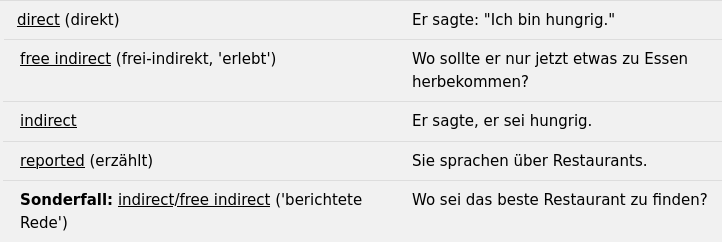

The speech type is added in form of a dictionary `{speech_type : score}`. For tokens, the score ranges between 0 and 1 (it is the probability that the token belongs to that speech type). For clauses, the score ranges between 0 and (number of tokens in the clause)+1 (it is the product probability plus the number of tokens in the clause that belong to the speech type). Higher scores indicate a higher certainty, but the scores are not relevant for us.

In [53]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# Add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(dependency_clausizer, name="clausizer")
nlp.add_pipe(quotation_marks_speech_tagger, name="speech_tagger")

In [54]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc_goethe_wahlverwandtschaften = nlp(text_goethe_wahlverwandtschaften[24399:33069])

In [55]:
# Text snippet that we will work with in the following:
print(doc_goethe_wahlverwandtschaften[704:928])

Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen.
Der Nachtisch war aufgetragen, als der Gast seine Wirte ernstlich vermahnte, nicht weiter mit ihren Entdeckungen zurückzuhalten, weil er gleich nach dem Kaffee fort müsse. Die beiden Eheleute machten umständlich ihre Bekenntnisse; aber kaum hatte er den Sinn der Sache vernommen, als er verdrießlich vom Tische auffuhr, ans Fenster sprang und sein Pferd zu satteln befahl.
»Entweder ihr kennt mich nicht,« rief er aus, »ihr versteht mich nicht, oder ihr seid sehr boshaft. Ist denn hier ein Streit? Ist denn hier eine Hülfe nötig? Glaubt ihr, daß ich in der Welt bin, um Rat zu geben? Das ist das dümmste Handwerk, das einer treiben kann. Rate sich jeder selbst und tue, was er nicht lassen kann. Gerät es gut, so freue er sich seiner Weisheit und seines Glücks; läufts übel ab, dann bin ich bei der Hand. Wer ein Übel los sein will, der wei

In [56]:
# Speech tagger output for clauses of text snippet above:
for i, clause in enumerate(doc_goethe_wahlverwandtschaften._.clauses[99:134]):
    print(i, clause, clause._.speech)

0 Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen {}
1 die auf die Namensbedeutungen abergläubisch {}
2 sind {}
3 behaupten {}
4 der Name Mittler habe ihn genötigt {}
5 Der Nachtisch war aufgetragen {}
6 als der Gast seine Wirte ernstlich vermahnte {}
7 nicht weiter mit ihren Entdeckungen zurückzuhalten {}
8 weil er gleich nach dem Kaffee fort müsse {}
9 Die beiden Eheleute machten umständlich ihre Bekenntnisse {}
10 aber kaum hatte er den Sinn der Sache vernommen {}
11 als er verdrießlich vom Tische auffuhr {}
12 ans Fenster sprang und sein Pferd zu satteln befahl {}
13 und sein Pferd zu satteln {}
14 Entweder ihr kennt mich nicht,« rief er aus {'direct': 8.0}
15 ihr versteht mich nicht {'direct': 5.0}
16 oder ihr seid sehr boshaft {'direct': 6.0}
17 Ist denn hier ein Streit {'direct': 6.0}
18 Ist denn hier eine Hülfe nötig {'direct': 7.0}
19 Glaubt ihr {'direct': 3.0}
20 daß 

#### Task
In the following cells, we create a new pipeline that includes the neural speech tagger that includes additional labels (`freeIndirect`, `direct`, `reported`). Pipe the same text snippet and compare the output of the rule-based speech tagger above with the neural speech-tagger. Pay attention to the labels that are not present in the rule-based tagger – 

**Note:** Some pipeline components take some time to compute, hence we prepared this before the workshop.
In the following block we create a pipeline that loads the pre-computed results. The lines commented out show how it would look without loading prepared results.

In [57]:
# Create pipeline object
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# Add components
nlp.add_pipe(spacy_sentencizer, name="sentencizer", before="parser")
nlp.add_pipe(dependency_clausizer, name="clausizer")
nlp.add_pipe(flair_speech_tagger, name="speech_tagger")

In [58]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc_goethe_wahlverwandtschaften = nlp(text_goethe_wahlverwandtschaften[24399:33069])

2023-04-14 19:49:36,363 loading file /home/fbarth/.flair/models/indirect/final-model.pt
2023-04-14 19:49:37,111 loading file /home/fbarth/.flair/models/freeIndirect/final-model.pt
2023-04-14 19:49:37,776 loading file /home/fbarth/.flair/models/direct/final-model.pt
2023-04-14 19:49:43,024 loading file /home/fbarth/.flair/models/reported/final-model.pt


In [59]:
# your code here






##### possible solution

Code
```
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc = nlp(text_goethe_wahlverwandtschaften[24399:33069])
for i, clause in enumerate(doc._.clauses[99:134]):
    print(i, clause, clause._.speech)
```

Observations

In the first part of the text, the neural tagger correctly regognises indirect speech:
```
0 Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen {'indirect': 7.5311426124804175}
1 die auf die Namensbedeutungen abergläubisch {}
2 sind {}
3 behaupten {}
4 der Name Mittler habe ihn genötigt {'indirect': 6.516442565492913}
5 Der Nachtisch war aufgetragen {}
6 als der Gast seine Wirte ernstlich vermahnte {}
7 nicht weiter mit ihren Entdeckungen zurückzuhalten {'indirect': 6.1728297341784595}
8 weil er gleich nach dem Kaffee fort müsse {'indirect': 8.377012617584246}
```

The neural tagger identifies reported speech:
```
9 Die beiden Eheleute machten umständlich ihre Bekenntnisse {'reported': 7.294128802971696}
```

Furthermore, it identifies clauses with mixed proportions of speech:
```
19 Glaubt ihr {'direct': 2.9845665153452963}
20 daß ich in der Welt bin {'indirect': 6.384563263299, 'direct': 6.970067813120923}
21 um Rat zu geben {'indirect': 4.9464183341046315, 'direct': 4.973735076951577, 'reported': 4.292892000878954}
```

In [60]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc = nlp(text_goethe_wahlverwandtschaften[24399:33069])
for i, clause in enumerate(doc._.clauses[99:134]):
    print(i, clause, clause._.speech)

0 Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen {'indirect': 7.5311426124804175}
1 die auf die Namensbedeutungen abergläubisch {}
2 sind {}
3 behaupten {}
4 der Name Mittler habe ihn genötigt {'indirect': 6.516443031064316}
5 Der Nachtisch war aufgetragen {}
6 als der Gast seine Wirte ernstlich vermahnte {}
7 nicht weiter mit ihren Entdeckungen zurückzuhalten {'indirect': 6.1728297341784595}
8 weil er gleich nach dem Kaffee fort müsse {'indirect': 8.377012617584246}
9 Die beiden Eheleute machten umständlich ihre Bekenntnisse {'reported': 7.294128802971696}
10 aber kaum hatte er den Sinn der Sache vernommen {}
11 als er verdrießlich vom Tische auffuhr {}
12 ans Fenster sprang und sein Pferd zu satteln befahl {}
13 und sein Pferd zu satteln {}
14 Entweder ihr kennt mich nicht,« rief er aus {'direct': 7.983966533851929}
15 ihr versteht mich nicht {'direct': 4.988870485624152}
16

# Optional Tasks

When you are done with the notebook and still have time, you can try to solve the following tasks on your own.

1. Preparation.
    - a) Read the Fontane's *Der Stechlin*.
    - b) Build a spaCy pipeline.
    - c) Pipe the text through the pipeline.
2. Corpus statistics.
    - a) How much of the text is written in past tense? Determine the percentage of clauses.
    - b) How much of the text is direct speech? Determine the percentage of clauses or tokens.
    - c) How many of the named entities in the text contain the word "Stechlin"? Determine the percentage of named entities.

Read in Fontane's *Der Stechlin*:

In [61]:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text

Build a spaCy pipeline:

In [62]:
nlp = spacy.load(os.path.join(PARSING_PATH, "de_ud_lg"))
# add the components you need with the `add_pipe` method here

Use the following block to work on the exercise questions.

In [ ]:
# your code here:




